---
title: Non-Hierarchical Logistic and Bayesian Binomial Models
subject: Methods
subtitle: Facility-level SSI risk modeling without partial pooling
exports: 
  - format: pdf
    template: curvenote
    # template: arxiv_two_column # requires abstract
  # - format: pdf+tex
keywords: [logistic regression, Bayesian binomial model, surgical site infection, hospital performance, facility-level risk, statistical modeling, healthcare quality]
---

In [1]:
#| load-data
library(arrow)
library(rjags)

# Load data
colon_fac_ach <- read_parquet("data/colon_fac_ach.parquet")

Warning message:
“package ‘arrow’ was built under R version 4.5.2”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



## Binomial logistic regression

Below, a standard logistic regression model is fit to the data. `Community, <125 Beds` facilities are used for the reference group.

In [2]:
lr_fit <- glm(cbind(Infections_Reported, No_Infections) ~ Facility_Type,
              data = colon_fac_ach, family = binomial)

summary(lr_fit)


Call:
glm(formula = cbind(Infections_Reported, No_Infections) ~ Facility_Type, 
    family = binomial, data = colon_fac_ach)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -4.3979     0.2012 -21.856  < 2e-16 ***
Facility_TypeCommunity, >250 Beds      0.6069     0.2194   2.767  0.00566 ** 
Facility_TypeCommunity, 125-250 Beds   0.4526     0.2326   1.946  0.05165 .  
Facility_TypeMajor Teaching            0.6122     0.2076   2.949  0.00318 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 495.24  on 287  degrees of freedom
Residual deviance: 483.68  on 284  degrees of freedom
AIC: 977.75

Number of Fisher Scoring iterations: 5


The standard logistic regression with facility type as the only factor with 4 levels produces only 4 predicted probabilities, which does not adequately explain the large variation observed across individual facilities. This model treats all facilities of the same type identically, ignoring facility volume and county-level effects.

## Bayesian binomial model

The Bayesian binomial model is fit next. Weakly informative $\text{N}(0, 5^2)$ priors are used for the parameters.

$$
\begin{aligned}
y_i \mid \phi_i &\sim \text{Binomial}(n_i, \phi_i), \quad i = 1, \dots, 288 \\
\text{logit}(\phi_i) &= \beta_0 + \beta_1 \cdot \text{beds}_{125\text{-}250,i} + 
                        \beta_2 \cdot \text{beds}_{>250,i} + 
                        \beta_3 \cdot \text{major\_teach}_i \\
\beta_j &\sim \text{Normal}(0, 5^2), \quad j = 0,1,2,3
\end{aligned}
$$

### JAGS model syntax

In [3]:
## Non-hierarchical Bayesian binomial model

# Transform data for JAGS; use Community, <125 Beds for reference level
data_jags_nh <- list(
  y = colon_fac_ach$Infections_Reported,
  n = colon_fac_ach$Procedure_Count,
  beds_125to250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, 125-250 Beds'),
  beds_gt250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, >250 Beds'),
  major_teach = as.numeric(colon_fac_ach$Facility_Type == 'Major Teaching'),
  N = nrow(colon_fac_ach),
  J = 3  # number of predictors
)

# Model syntax
mod_string_nh <- " model {
  # likelihood
  for (i in 1:N) {
    y[i] ~ dbin(p[i], n[i])
    logit(p[i]) <- b0 + b[1]*beds_125to250[i] + b[2]*beds_gt250[i] + 
                        b[3]*major_teach[i]
  }

  # priors
  b0 ~ dnorm(0, 1.0/5^2)
  for (j in 1:J) {
    b[j] ~ dnorm(0.0, 1.0/5^2)  # weakly informative priors (sd ~5)
  }
} "

# Model setup
set.seed(530)

mod_nh <- jags.model(textConnection(mod_string_nh),
                     data = data_jags_nh,
                     n.chains = 3)

update(mod_nh, 5000)  # burn-in

params_nh <- c("b0", "b")

# Run model
mod_sim_nh <- coda.samples(mod_nh, variable.names = params_nh, n.iter = 5e4)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 288
   Unobserved stochastic nodes: 4
   Total graph size: 1466

Initializing model



### Trace plots

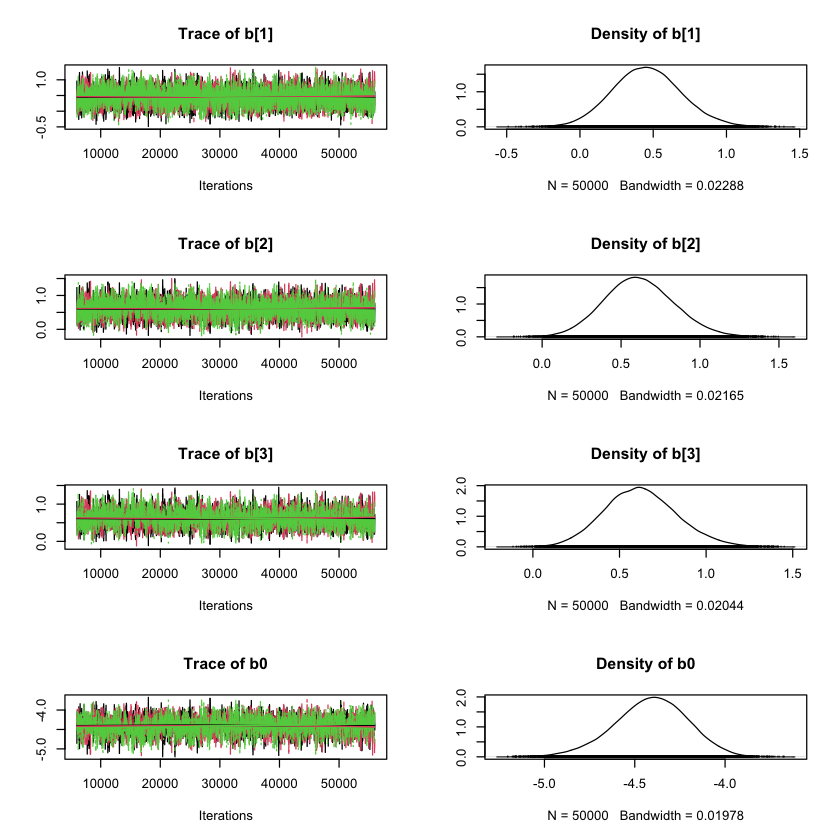

In [4]:
plot(mod_sim_nh)

### Diagnostics

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1       1.01
b[2]          1       1.01
b[3]          1       1.01
b0            1       1.01

Multivariate psrf

1

,b[1],b[2],b[3],b0
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000
Lag 1,0.8101299,0.8812219,0.9543973,0.9695504
Lag 5,0.6870262,0.7694887,0.8583176,0.8764548
Lag 10,0.6079834,0.6812631,0.7579575,0.7746013
Lag 50,0.2285964,0.2559440,0.2864848,0.2935481


b[1]     b[2]     b[3]       b0 
2375.626 2152.817 1923.219 1888.709

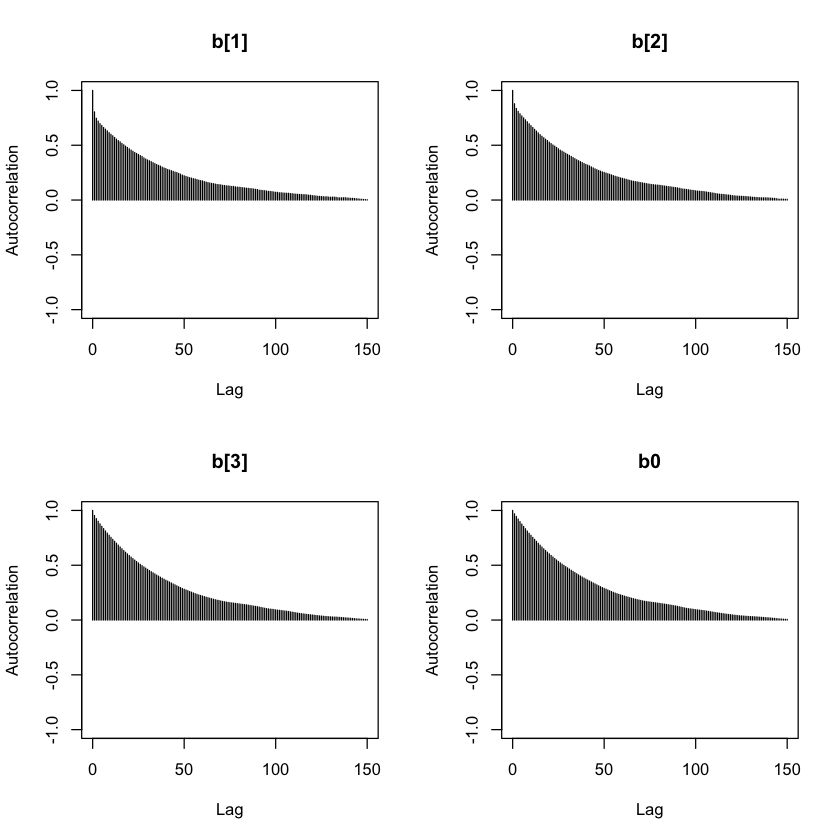

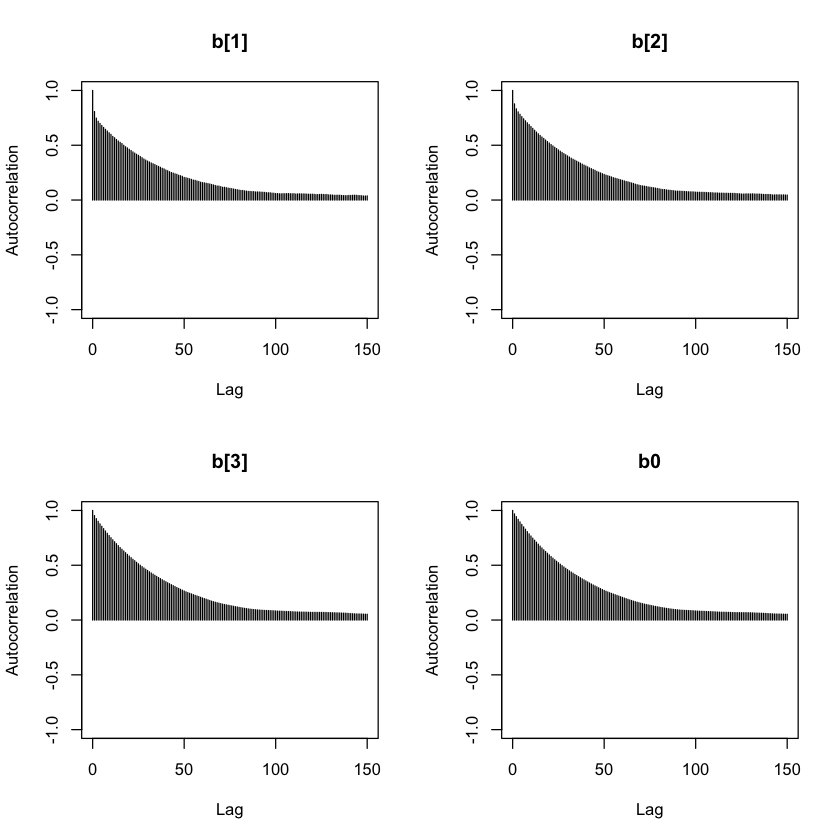

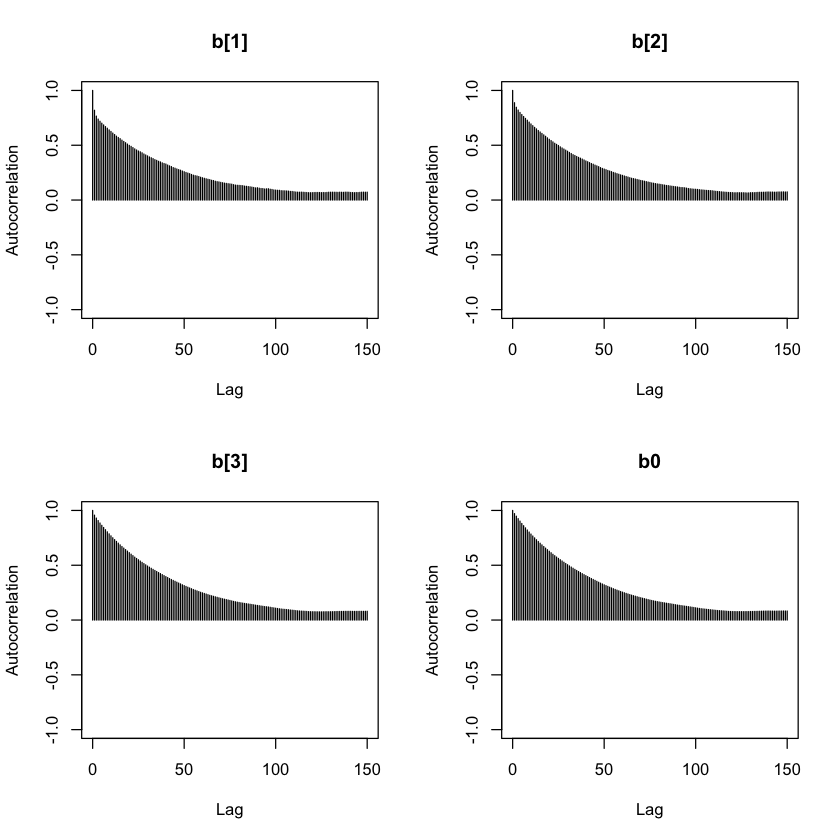

In [5]:
gelman.diag(mod_sim_nh)

autocorr.diag(mod_sim_nh)

effectiveSize(mod_sim_nh)

autocorr.plot(mod_sim_nh, lag.max = 150)

In [6]:
raftery.diag(mod_sim_nh)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 45       48168  3746         12.9      
 b[2] 50       54400  3746         14.5      
 b[3] 72       75864  3746         20.3      
 b0   99       107487 3746         28.7      


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 35       44233  3746         11.8      
 b[2] 50       53980  3746         14.4      
 b[3] 52       82290  3746         22.0      
 b0   110      122375 3746         32.7      


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                            
      Burn-in  Total Lower bound  Dependence
      (M)      (N)   (Nmin)    

In [7]:
(dic_nh <- dic.samples(mod_nh, n.iter = 1e3))

Mean deviance:  973.5 
penalty 3.65 
Penalized deviance: 977.1 

In [8]:
summary(mod_sim_nh)


Iterations = 6001:56000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD  Naive SE Time-series SE
b[1]  0.4575 0.2340 0.0006043       0.004813
b[2]  0.6149 0.2215 0.0005720       0.004786
b[3]  0.6228 0.2092 0.0005403       0.004775
b0   -4.4097 0.2030 0.0005240       0.004676

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
b[1]  0.01216  0.2976  0.4529  0.6113  0.935
b[2]  0.19732  0.4634  0.6081  0.7604  1.068
b[3]  0.23106  0.4785  0.6159  0.7587  1.056
b0   -4.83405 -4.5411 -4.4022 -4.2700 -4.032
